Web Scraping/ETL
We are going to extract information from a website's table using beautifulsoup and requests libraries to parse the html text into python. Data will be stored in a csv file so that it can be later inserted into SQL Server Management Studio.

In [1]:
#importing libraries
from bs4 import BeautifulSoup
import requests
import csv
import os
import pandas as pd
import pyodbc as db


Before pulling any data, first we use the pyodbc library to connect to 
SQL Server Management Studio.

In [2]:
#Connecting to sql server
try:
    conn=db.connect("Driver={SQL SERVER};"
                    "Server=LAPTOP-DOU6HMTK\SQLEXPRESS;"
                    "Database=Soccer_;"
                    "Trusted_Connection=yes")
    cur = conn.cursor()
except:
    print("Database connection error")
    raise


Once the connection it's established , we create the table in which we are going to insert
all the data that we get from the website.

In [3]:
drop_if ="""    DROP TABLE IF EXISTS La_Liga_Classification ;"""
cur.execute(drop_if)
create_table = """CREATE TABLE La_Liga_Classification(
        Abreviation varchar(260),
        Team varchar(260),
        Points Int,
        Games_played int,
        Games_tied int,
        Games_won int,
        Games_lost int,
        Goals_scored int,
        Goals_against int,
        Goals_difference int
        );"""
cur.execute(create_table)
conn.commit()


This is the website from which we are going to extract the information;
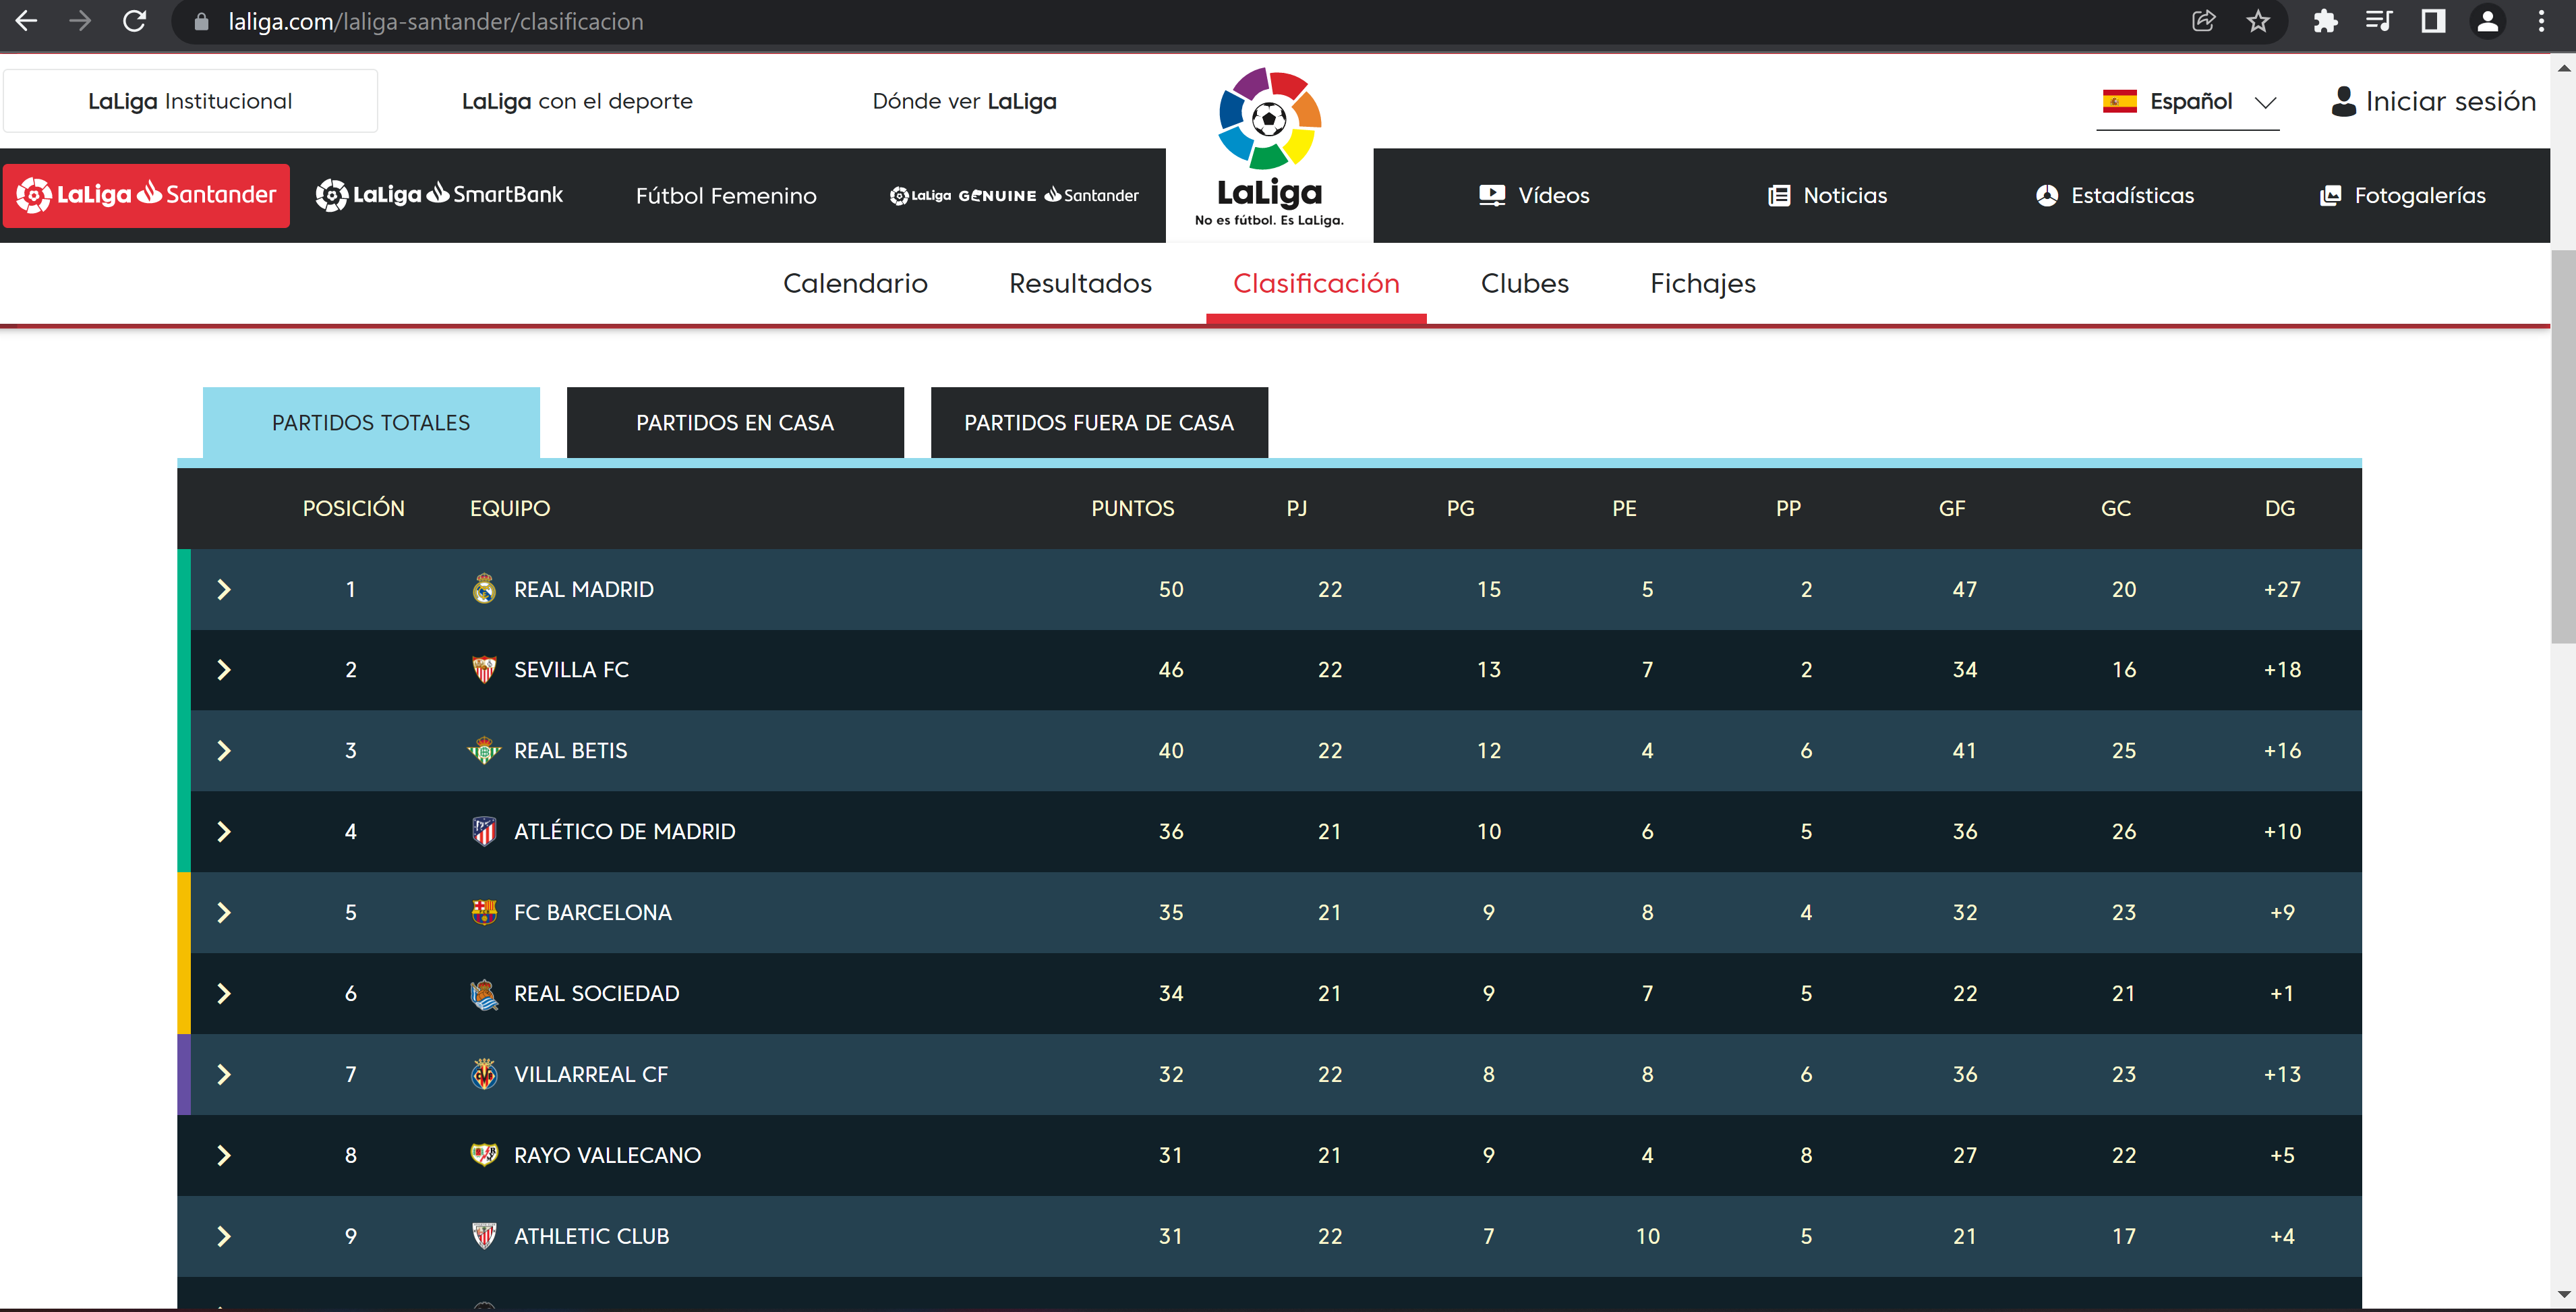

EXTRACT:
In this section we establish the path to where the csv file will be written.
After that, we use the Beautifulsoup library to navigate through the html tags of the website
and pull the information from the table.

In [4]:
#Setting up path and csv file name
name="Laliga_results_fixed.csv"
path ="C:\\Users\\Servando\\Documents\\Datasets\\my_csvs\\"
complete = os.path.join(path,name)
#Requesting html and creating a BeautifulSoup object
url ='https://www.laliga.com/laliga-santander/clasificacion'
data = requests.get(url).text
obj1= BeautifulSoup(data,'html.parser')

#Navigating the tags to extract the information of interest
rows = obj1.find_all("p",{'class':{'styled__TextRegularStyled-sc-1raci4c-0 glrfl','styled__TextRegularStyled-sc-1raci4c-0 cIcTog'}},limit=210)

TRANSFORM:
Here, we process the text that was pulled from the html tags in  "obj1".

In [5]:
#Data wrangling/processing

idx=0
complete_list=[]
new_list=[]

txt = [row for row in rows[10:]]


for i in txt:
    if idx !=10:
        new_list.extend(i)
    else:
        complete_list.append(new_list)
        idx=0
        new_list=[]
        new_list.extend(i)

    idx+=1

Now that the text it's in a list of lists we can write a csv file.
Also we read that same csv file to put it in a pandas dataframe that will allows us to insert it later on.

In [11]:
#Creating top columns and writing csv file with clean data
column_names = ['Abreviation','Team','Points','Games_played','Games_won','Games_tied','Games_lost','Goals_scored','Goals_against','Goals_difference']
with open(complete,"w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    for info in complete_list:
        writer.writerow(info)

df1=pd.read_csv(r"C:\Users\Servando\Documents\Datasets\my_csvs\Laliga_results_fixed.csv",encoding="ISO-8859-1")

LOAD:
We iterate over the dataframe to insert it row by row into the table we created before, note that we have to cast its elements into integers/strings so that  our table accepts them.

In [8]:
  my_frame=pd.DataFrame(df1)
for index,r in my_frame.iterrows():
    cur.execute("INSERT INTO La_Liga_Classification("
                "Abreviation,"
                "Team,"
                "Points,"
                "Games_played,"
                "Games_won,"
                "Games_tied,"
                "Games_lost,"
                "Goals_scored,"
                "Goals_against,"
                "Goals_difference) values(?,?,?,?,?,?,?,?,?,?)",
                str(r['Abreviation']),str(r['Team']),int(r['Points']),int(r['Games_played']),int(r['Games_won']),int(r['Games_tied']),int(r['Games_lost']),int(r['Goals_scored']),int(r['Goals_against']),int(r['Goals_difference']))
                    
                    
            
conn.commit()


Finally we check if the information it's truly in  the database by running a sql query against it.

In [12]:
#Checking what's in the table
check_query= "SELECT * FROM La_Liga_Classification;"
print(pd.read_sql(check_query,conn))

   Abreviation                       Team  Points  Games_played  Games_tied  \
0          RMA                Real Madrid      50            22           5   
1          SEV                 Sevilla FC      46            22           7   
2          BET                 Real Betis      40            22           4   
3          ATM         Atlético de Madrid      36            21           6   
4          BAR               FC Barcelona      35            21           8   
5          RSO              Real Sociedad      34            21           7   
6          VIL              Villarreal CF      32            22           8   
7          RAY             Rayo Vallecano      31            21           4   
8          ATH              Athletic Club      31            22          10   
9          VAL                Valencia CF      29            22           8   
10         OSA                 CA Osasuna      28            22           7   
11         CEL                   RC Celta      27   